GENERATING S-PARAMETER SIGNAL HEATMAPS (Sharp vs Graded)
Simulating...


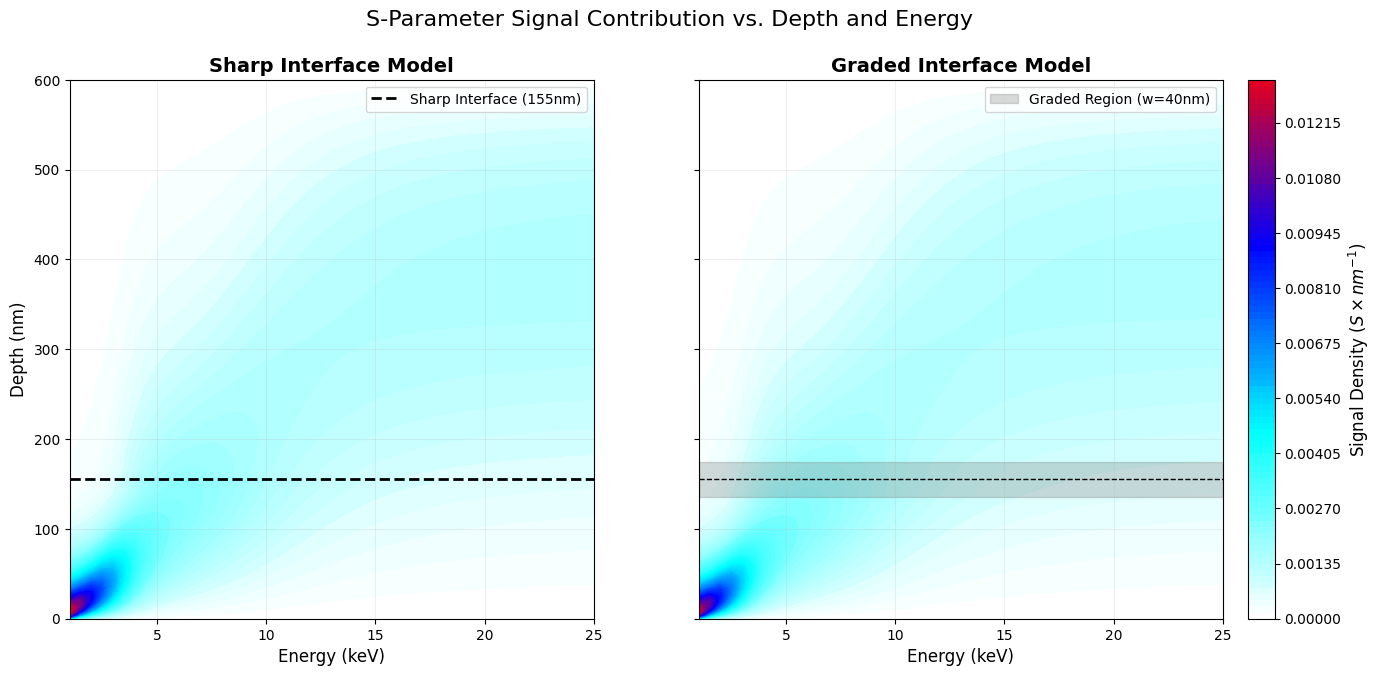

Done! Saved to 'comparison_heatmap.pdf'


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.insert(0, r'C:\Users\jeanv\OneDrive - Delft University of Technology\Uitwisseling - TUDelft\Courses\MEP\Programming')

import numpy as np
import matplotlib.pyplot as plt

# Import your physics engine
from pals_analysis.physics.implantation import makhov_profile
from pals_analysis.physics.annihilation import calculate_annihilation_profile

def get_s_map(z_grid, layers, model='sharp', w=10.0):
    """
    Helper to generate the S-parameter Depth Profile S(z).
    """
    d_ox = layers[0]['thickness']
    s_surf = 0.575 # Oxide S
    s_bulk = 0.520 # Steel S
    
    if model == 'graded':
        # Sigmoid transition for S-parameter
        return s_surf + (s_bulk - s_surf) / (1 + np.exp(-(z_grid - d_ox) / (w/4.0)))
    else:
        # Sharp Step
        return np.where(z_grid <= d_ox, s_surf, s_bulk)

def run_comparison():
    print("="*60)
    print("GENERATING S-PARAMETER SIGNAL HEATMAPS (Sharp vs Graded)")
    print("="*60)

    # 1. SETUP
    energies = np.linspace(1, 25, 50)
    z_grid = np.linspace(0, 600, 300) # Zoom in to top 600nm
    
    layers = [
        {'thickness': 155, 'density': 5.24, 'L_diff': 30},   # Oxide
        {'thickness': 1000, 'density': 8.00, 'L_diff': 150}   # Steel
    ]
    
    # 2. SIMULATION LOOP
    # We will store the "Signal Density" matrices
    sig_matrix_sharp = []
    sig_matrix_graded = []
    
    # Get S(z) profiles for both models
    s_z_sharp = get_s_map(z_grid, layers, model='sharp')
    s_z_graded = get_s_map(z_grid, layers, model='graded', w=40.0) # Broad 40nm interface

    print("Simulating...")
    for E in energies:
        # --- SHARP MODEL ---
        p_s = makhov_profile(z_grid, E, layers, model='sharp')
        c_s = calculate_annihilation_profile(z_grid, p_s, layers, model='sharp')
        # Signal = Probability Density * Local S-Value
        sig_matrix_sharp.append(c_s * s_z_sharp)

        # --- GRADED MODEL ---
        p_g = makhov_profile(z_grid, E, layers, model='graded', w=40.0)
        c_g = calculate_annihilation_profile(z_grid, p_g, layers, model='graded', w=40.0)
        sig_matrix_graded.append(c_g * s_z_graded)

    # Convert to arrays for plotting (Shape: Energies x Depths)
    sig_matrix_sharp = np.array(sig_matrix_sharp)
    sig_matrix_graded = np.array(sig_matrix_graded)

    # 3. PLOTTING
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    
    # Custom colormap (White -> Blue -> Red) for signal intensity
    cmap = LinearSegmentedColormap.from_list('signal', ['white', 'cyan', 'blue', 'red'], N=100)
    
    # Find global max/min for consistent colorbar
    vmax = max(sig_matrix_sharp.max(), sig_matrix_graded.max())
    
    # --- PLOT 1: SHARP ---
    im1 = ax1.contourf(energies, z_grid, sig_matrix_sharp.T, levels=100, cmap=cmap, vmin=0, vmax=vmax)
    ax1.axhline(155, color='black', linestyle='--', linewidth=2, label='Sharp Interface (155nm)')
    ax1.set_title("Sharp Interface Model", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Depth (nm)", fontsize=12)
    ax1.set_xlabel("Energy (keV)", fontsize=12)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.2)

    # --- PLOT 2: GRADED ---
    im2 = ax2.contourf(energies, z_grid, sig_matrix_graded.T, levels=100, cmap=cmap, vmin=0, vmax=vmax)
    
    # Draw the "Transition Zone"
    ax2.axhline(155, color='black', linestyle='--', linewidth=1)
    ax2.axhspan(155-20, 155+20, color='gray', alpha=0.3, label='Graded Region (w=40nm)')
    
    ax2.set_title("Graded Interface Model", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Energy (keV)", fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.2)

    # Colorbar
    cbar = fig.colorbar(im2, ax=[ax1, ax2], orientation='vertical', fraction=0.05, pad=0.02)
    cbar.set_label(r'Signal Density ($S \times nm^{-1}$)', fontsize=12)

    plt.suptitle("S-Parameter Signal Contribution vs. Depth and Energy", fontsize=16)
    plt.savefig("comparison_heatmap.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    print("Done! Saved to 'comparison_heatmap.pdf'")

if __name__ == "__main__":
    run_comparison()